In [ ]:
!pip install -q -U watermark
!pip install -qq transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.19.4
pandas 1.1.5
torch 1.7.0+cu101
transformers 4.1.1


In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 113MB/s]


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/TRS/places.xlsx")
df.head(403)

,Destination,Place,Rating,Description,religious / non religious,conventional / adventurous,commotion / peaceful,fun / beauty
0,Goa,Calangute Beach,4.4,Calangute is a largest beach in north Goa stre...,1.0,1.0,0.0,1.0
1,Goa,Basilica of Bom Jesus,4.3,This historic church is located in Goa and is ...,0.0,0.0,1.0,0.0
2,Goa,Water Sports in Goa,4.4,Goa is a haven for water sports like kneeboard...,1.0,1.0,0.0,1.0
3,Goa,Fort Aguada,4.4,Fort Aguada is a 17th-century Portuguese fort ...,1.0,0.0,1.0,1.0
4,Goa,Baga Beach,4.5,"One of the most popular beaches in North Goa, ...",1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
398,Mumbai,Lokhandwala Market,3.3,Lokhandwala is another place to shop happily a...,1.0,0.0,0.0,0.0
399,Mumbai,"Hill Road and Linking Road, Bandra",3.3,"Acknowledged for its high fashionable taste, M...",NaN,NaN,NaN,NaN
400,Mumbai,Makarandgad Trek,3.5,Makarandgad (or Madhumakarandgad) is a hill fo...,NaN,NaN,NaN,NaN
401,Mumbai,Bhimashankar Trek,3.5,Located in the beautiful expanses of the Weste...,NaN,NaN,NaN,NaN


In [ ]:
df1 = df.iloc[:350,:]
df2 = df.iloc[350: 399, :]
df3 = df.iloc[399:, :]

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []

for txt in df1.Description:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

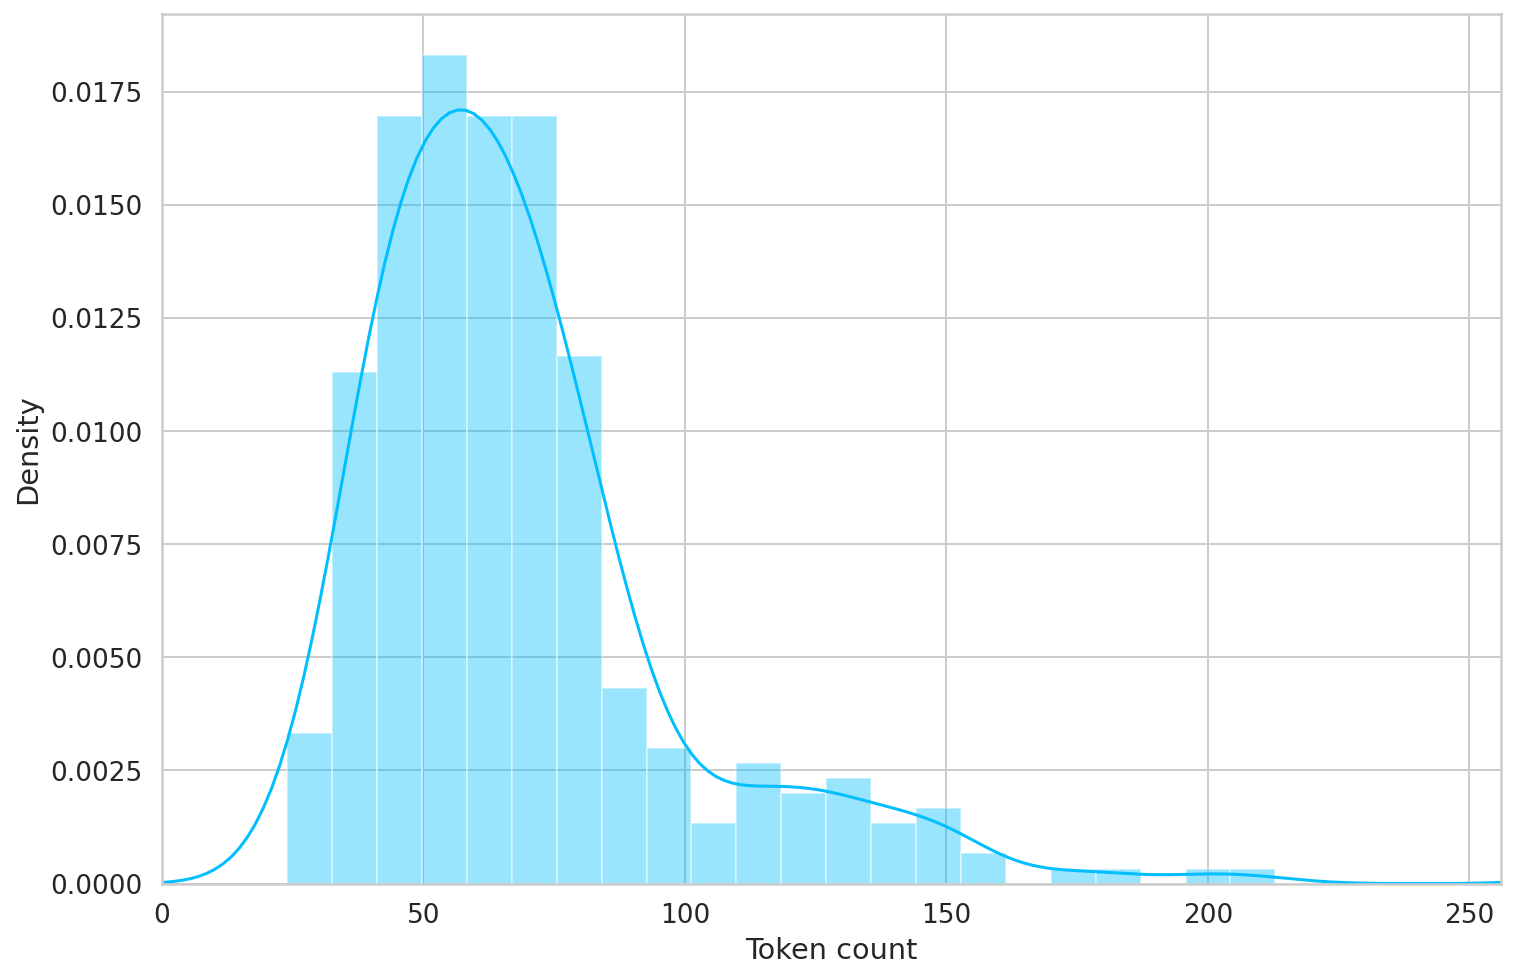

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 225

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, description, religious, conventional, commotion, fun, tokenizer, max_len):
    self.description = description
    self.religious = religious
    self.conventional = conventional
    self.commotion = commotion
    self.fun = fun
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.description)
  
  def __getitem__(self, item):
    review = str(self.description[item])
    target = np.array([self.religious[item], self.conventional[item], self.commotion[item], self.fun[item]])

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'description_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.float)
    }

In [ ]:
df1 = df1.rename(columns = {'religious / non religious': 'religious', 'conventional / adventurous': 'conventional', 'commotion / peaceful':  'commotion', 'fun / beauty': 'fun' })
df2 = df2.rename(columns = {'religious / non religious': 'religious', 'conventional / adventurous': 'conventional', 'commotion / peaceful':  'commotion', 'fun / beauty': 'fun' })
df3 = df3.rename(columns = {'religious / non religious': 'religious', 'conventional / adventurous': 'conventional', 'commotion / peaceful':  'commotion', 'fun / beauty': 'fun' })

In [ ]:
def create_data_loader(df1, tokenizer, max_len, batch_size, shuffle = True):
  ds = GPReviewDataset(
    description=df1.Description.to_numpy(),
    religious=df1.religious.to_numpy(),
    conventional = df1.conventional.to_numpy(),
    commotion = df1.commotion.to_numpy(),
    fun = df1.fun.to_numpy(),  
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0, 
    shuffle = shuffle
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df1, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df2, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['description_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 225])
torch.Size([16, 225])
torch.Size([16, 4])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )['pooler_output']
    #print(pooled_output)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = ['religious', 'conventional', 'commotion', 'fun']

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCEWithLogitsLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    #print(outputs)
    sigmoid = nn.Sigmoid()(outputs)
    #_, preds = torch.max(sigmoid, dim=1)
    preds = torch.round(sigmoid)
    #print(sigmoid)
    #print(preds)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / (n_examples*4), np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      sigmoid = nn.Sigmoid()(outputs)
      #_, preds = torch.max(sigmoid, dim=1)
      preds = torch.round(sigmoid)
      #print(sigmoid)
      #print(preds)
      loss = loss_fn(outputs, targets)
      #_, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / (n_examples*4), np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df1)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df2)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/TRS/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.5592141923579302 accuracy 0.7235714285714285
Val   loss 0.48544616252183914 accuracy 0.7653061224489796

Epoch 2/3
----------
Train loss 0.38666819577867334 accuracy 0.8442857142857143
Val   loss 0.43571116775274277 accuracy 0.8316326530612245

Epoch 3/3
----------
Train loss 0.29692303524775937 accuracy 0.8907142857142857
Val   loss 0.4299726039171219 accuracy 0.846938775510204

CPU times: user 30.6 s, sys: 20.4 s, total: 51 s
Wall time: 54.3 s


In [ ]:
test_data_loader = create_data_loader(df3, tokenizer, MAX_LEN, 23, False)

In [ ]:
def test_epoch(
  model, 
  data_loader,   
  device, 
):
  model = model.eval()
  ultimate_prediction = []
  with torch.no_grad():

  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )

        #print(outputs)
        sigmoid = nn.Sigmoid()(outputs)
        #_, preds = torch.max(sigmoid, dim=1)
        preds = torch.round(sigmoid).cpu()
        ultimate_prediction.append(preds)
    
  return np.concatenate(ultimate_prediction)

In [ ]:
pred = test_epoch(model, test_data_loader, device)
pred.shape

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(2231, 4)

In [ ]:
pred = pd.DataFrame(pred, columns = class_names)
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231 entries, 0 to 2230
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   religious     2231 non-null   float32
 1   conventional  2231 non-null   float32
 2   commotion     2231 non-null   float32
 3   fun           2231 non-null   float32
dtypes: float32(4)
memory usage: 35.0 KB


In [ ]:
df3 = df3[['Destination', 'Place', 'Rating', 'Description']]
df3 = pd.concat([df3, pred], axis = 1)
df3.to_csv('/content/drive/MyDrive/Colab Notebooks/TRS/final_pred.csv', index = False)


In [ ]:
finaldf = pd.concat([df1, df2, df3])
finaldf.to_excel('/content/drive/MyDrive/Colab Notebooks/TRS/final_places.xlsx', index = False)

In [ ]:
pred.isna().any()

religious       False
conventional    False
commotion       False
fun             False
dtype: bool